In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)

### **Importing Libraries and Pre-trained networks**

In [ ]:
!pip3 install resnet

In [48]:
from keras.preprocessing import image
# Transfer Learning Models
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet152

from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet 
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing.image import ImageDataGenerator

# Layers
from keras.layers import Dense, Activation, Flatten, Dropout
from keras import backend as K

# Other
from keras import optimizers
from keras import losses
from keras.optimizers import SGD, Adam
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,MaxPool2D , GlobalAveragePooling2D , AveragePooling2D , BatchNormalization

# Utils
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import cohen_kappa_score , matthews_corrcoef , classification_report , roc_auc_score , accuracy_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import argparse
import random, glob
import os, sys, csv
import cv2
import time, datetime


### **Sample image from COVID dataset**

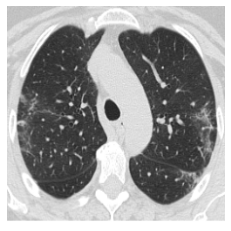

In [4]:
img = plt.imread("/content/drive/My Drive/dataset_pr/COVID/Covid (1).png")
img = cv2.resize(img,(224,224))
plt.imshow(img)
plt.axis("off")
plt.show()

### **Labelling images for Binary Classification**

In [5]:
x_ = list()
y = list()
IMG_SIZE = 224
c = 0
nc = 0
for i in os.listdir("/content/drive/My Drive/dataset_pr/COVID"):
    try:
        path = "/content/drive/My Drive/dataset_pr/COVID/"+i
        #print('1')
        img = cv2.imread(path)
        img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img_arr = np.asarray(img_)
        x_.append(img_arr)
        label = 0
        c = c+1
    except:
        None
for i in os.listdir("/content/drive/My Drive/dataset_pr/NON-COVID"):
    try:
        path = "/content/drive/My Drive/dataset_pr/NON-COVID/"+i
        img = cv2.imread(path)
        img_ = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img_arr = np.asarray(img_)
        x_.append(img_arr)
        label = 1
        nc = nc+1
    except:
        None

In [7]:
x1=[]
from keras.preprocessing import image
for item in x_:
      if len(item.shape) > 2 and item.shape[2] == 4:
            item = cv2.cvtColor(item, cv2.COLOR_BGRA2BGR)
      x1.append(item)
Y = []
for i in range(1252):
    Y.append(1)

for i in range(1229):
    Y.append(0)
X = np.asarray(x1)
y = np.asarray(Y)
print(X.shape)
from keras.utils import to_categorical
y= to_categorical(y, num_classes=2)
print(y.shape)

(2481, 224, 224, 3)
(2481, 2)


### **Split between train test and validation**

In [8]:
X_train, x_test, y_train, y_test = train_test_split(*shuffle(X, y) , test_size=0.10 , random_state=42)
X_train, x_val, y_train, y_val = train_test_split(*shuffle(X_train, y_train), test_size=0.10 , random_state=42)

### **Function for Confusion-Matrix**

In [9]:
def print_confusion_matrix():
    matrix = confusion_matrix(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1))
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,cmap='coolwarm',linecolor='white',linewidths=1,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### **Function for Model Accuracy vs Loss plot**

In [10]:
def plot_model_accuracy_loss():
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

### **Funtion for model performance parameters**

In [22]:
def print_performance_metrics():
    print('Accuracy:', np.round(metrics.accuracy_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('Precision:', np.round(metrics.precision_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1),average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)),4))
    print('ROC AUC:',roc_auc_score(y_test.argmax(axis=1),max_y_pred_test.argmax(axis=1))) 
    print('\t\tClassification Report:\n', metrics.classification_report(y_test.argmax(axis=1), max_y_pred_test.argmax(axis=1)))

### **VGG-19 Model**

In [53]:
baseModel = VGG19(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.9509 - accuracy: 0.6906 - val_loss: 0.6924 - val_accuracy: 0.7040
Epoch 2/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.4285 - accuracy: 0.8116 - val_loss: 0.4618 - val_accuracy: 0.7761
Epoch 3/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.2795 - accuracy: 0.8813 - val_loss: 0.4242 - val_accuracy: 0.8184
Epoch 4/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.2076 - accuracy: 0.9126 - val_loss: 0.3786 - val_accuracy: 0.8408
Epoch 5/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1526 - accuracy: 0.9469 - val_loss: 0.3285 - val_accuracy: 0.8582
Epoch 6/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1142 - accuracy: 0.9635 - val_loss: 0.3170 - val_accuracy: 0.8632
Epoch 7/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1037

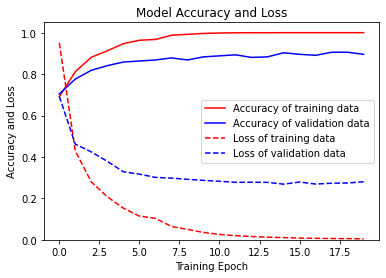

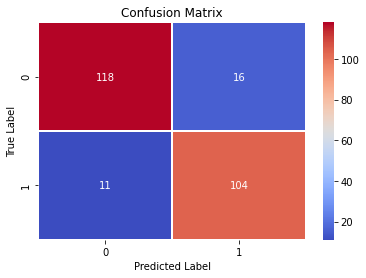

Accuracy: 0.8916
Precision: 0.8925
Recall: 0.8916
F1 Score: 0.8917
Cohen Kappa Score: 0.7825
Matthews Corrcoef: 0.7832
ROC AUC: 0.8924724205061649
		Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90       134
           1       0.87      0.90      0.89       115

    accuracy                           0.89       249
   macro avg       0.89      0.89      0.89       249
weighted avg       0.89      0.89      0.89       249



In [54]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **VGG-16 Model**

In [55]:
baseModel = VGG16(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model2 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model2.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model2.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 12s 7ms/step - loss: 1.0946 - accuracy: 0.6718 - val_loss: 0.6910 - val_accuracy: 0.7313
Epoch 2/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.4163 - accuracy: 0.8201 - val_loss: 0.5594 - val_accuracy: 0.7761
Epoch 3/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.3260 - accuracy: 0.8575 - val_loss: 0.4722 - val_accuracy: 0.8035
Epoch 4/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.2151 - accuracy: 0.9126 - val_loss: 0.4167 - val_accuracy: 0.8259
Epoch 5/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.1604 - accuracy: 0.9422 - val_loss: 0.4085 - val_accuracy: 0.8234
Epoch 6/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.1345 - accuracy: 0.9513 - val_loss: 0.3726 - val_accuracy: 0.8433
Epoch 7/20
1807/1807 [==============================] - 12s 7ms/step - loss: 0.0991

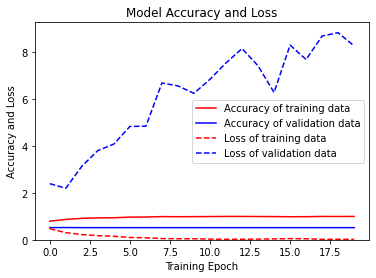

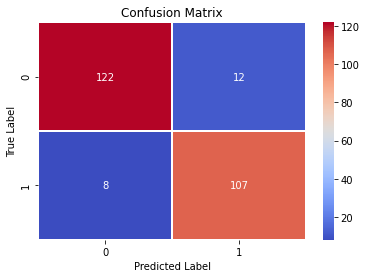

Accuracy: 0.9197
Precision: 0.9203
Recall: 0.9197
F1 Score: 0.9198
Cohen Kappa Score: 0.8388
Matthews Corrcoef: 0.8393
ROC AUC: 0.9204412719013627
		Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       134
           1       0.90      0.93      0.91       115

    accuracy                           0.92       249
   macro avg       0.92      0.92      0.92       249
weighted avg       0.92      0.92      0.92       249



In [59]:
y_pred_test = model2.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **ResNet50 Model**

In [57]:
baseModel = ResNet50(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model3 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
#opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model3.compile(loss="binary_crossentropy", optimizer='adam',metrics=["accuracy"])

history= model3.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.4711 - accuracy: 0.7919 - val_loss: 2.3889 - val_accuracy: 0.5174
Epoch 2/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.3032 - accuracy: 0.8672 - val_loss: 2.1950 - val_accuracy: 0.5224
Epoch 3/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.2241 - accuracy: 0.9123 - val_loss: 3.1279 - val_accuracy: 0.5174
Epoch 4/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1754 - accuracy: 0.9333 - val_loss: 3.7988 - val_accuracy: 0.5174
Epoch 5/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.1520 - accuracy: 0.9372 - val_loss: 4.0753 - val_accuracy: 0.5174
Epoch 6/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0991 - accuracy: 0.9657 - val_loss: 4.8229 - val_accuracy: 0.5174
Epoch 7/20
1807/1807 [==============================] - 14s 8ms/step - loss: 0.0848

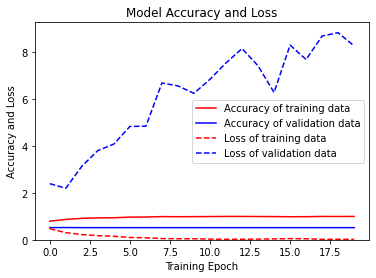

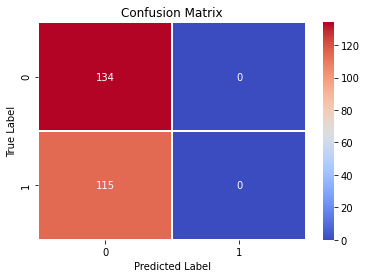

Accuracy: 0.5382
Precision: 0.2896
Recall: 0.5382
F1 Score: 0.3766
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC: 0.5
		Classification Report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70       134
           1       0.00      0.00      0.00       115

    accuracy                           0.54       249
   macro avg       0.27      0.50      0.35       249
weighted avg       0.29      0.54      0.38       249



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
y_pred_test = model3.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **InceptionV3 Model**

In [62]:
baseModel = InceptionV3(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model4 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model4.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model4.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 13s 7ms/step - loss: 0.5657 - accuracy: 0.7048 - val_loss: 10.8673 - val_accuracy: 0.4826
Epoch 2/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.4503 - accuracy: 0.7916 - val_loss: 9.8971 - val_accuracy: 0.5473
Epoch 3/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.4924 - accuracy: 0.7651 - val_loss: 23.2214 - val_accuracy: 0.5174
Epoch 4/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.3862 - accuracy: 0.8312 - val_loss: 13.2226 - val_accuracy: 0.5398
Epoch 5/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.3870 - accuracy: 0.8262 - val_loss: 24.8042 - val_accuracy: 0.5224
Epoch 6/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.3672 - accuracy: 0.8434 - val_loss: 28.3246 - val_accuracy: 0.5249
Epoch 7/20
1807/1807 [==============================] - 9s 5ms/step - loss: 0.3681 

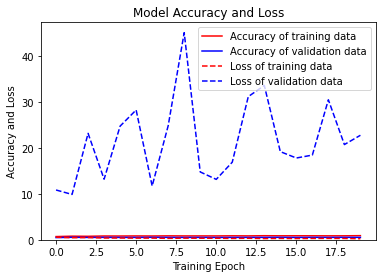

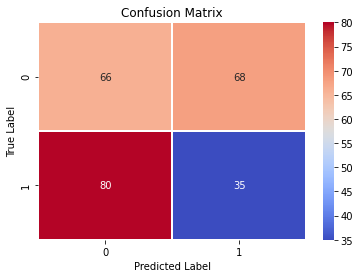

Accuracy: 0.4056
Precision: 0.4002
Recall: 0.4056
F1 Score: 0.402
Cohen Kappa Score: -0.2046
Matthews Corrcoef: -0.2056
ROC AUC: 0.3984425697598961
		Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.49      0.47       134
           1       0.34      0.30      0.32       115

    accuracy                           0.41       249
   macro avg       0.40      0.40      0.40       249
weighted avg       0.40      0.41      0.40       249



In [63]:
y_pred_test = model4.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **MobileNet Model**

In [64]:
baseModel = MobileNet(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model5 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model5.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model5.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.5193 - accuracy: 0.7313 - val_loss: 0.7057 - val_accuracy: 0.5050
Epoch 2/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.3093 - accuracy: 0.8705 - val_loss: 1.0220 - val_accuracy: 0.5174
Epoch 3/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.2255 - accuracy: 0.9076 - val_loss: 0.9195 - val_accuracy: 0.5199
Epoch 4/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.2372 - accuracy: 0.8998 - val_loss: 1.2960 - val_accuracy: 0.5174
Epoch 5/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.1758 - accuracy: 0.9228 - val_loss: 1.1219 - val_accuracy: 0.5174
Epoch 6/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.1299 - accuracy: 0.9427 - val_loss: 1.6701 - val_accuracy: 0.5174
Epoch 7/20
1807/1807 [==============================] - 6s 3ms/step - loss: 0.0755 - accu

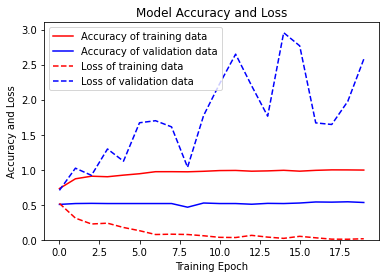

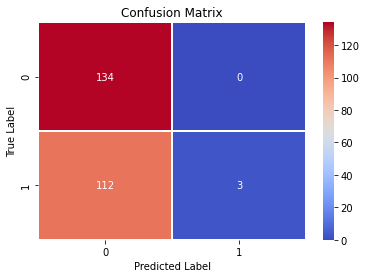

Accuracy: 0.5502
Precision: 0.755
Recall: 0.5502
F1 Score: 0.403
Cohen Kappa Score: 0.028
Matthews Corrcoef: 0.1192
ROC AUC: 0.5130434782608696
		Classification Report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.71       134
           1       1.00      0.03      0.05       115

    accuracy                           0.55       249
   macro avg       0.77      0.51      0.38       249
weighted avg       0.75      0.55      0.40       249



In [66]:
y_pred_test = model5.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **DenseNet169**

In [67]:
baseModel = DenseNet169(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model6 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model6.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model6.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 27s 15ms/step - loss: 0.5496 - accuracy: 0.6998 - val_loss: 1.4746 - val_accuracy: 0.5473
Epoch 2/20
1807/1807 [==============================] - 19s 11ms/step - loss: 0.3679 - accuracy: 0.8359 - val_loss: 2.5568 - val_accuracy: 0.5697
Epoch 3/20
1807/1807 [==============================] - 19s 11ms/step - loss: 0.2901 - accuracy: 0.8777 - val_loss: 2.2037 - val_accuracy: 0.5697
Epoch 4/20
1807/1807 [==============================] - 19s 11ms/step - loss: 0.2523 - accuracy: 0.8962 - val_loss: 2.1489 - val_accuracy: 0.5771
Epoch 5/20
1807/1807 [==============================] - 19s 11ms/step - loss: 0.2133 - accuracy: 0.9120 - val_loss: 1.9495 - val_accuracy: 0.5721
Epoch 6/20
1807/1807 [==============================] - 19s 11ms/step - loss: 0.1363 - accuracy: 0.9507 - val_loss: 3.4075 - val_accuracy: 0.5796
Epoch 7/20
1807/1807 [==============================] - 19s 11ms/step - loss:

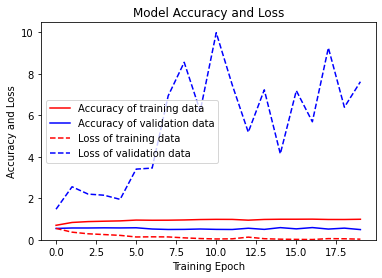

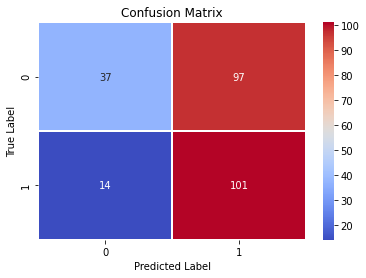

Accuracy: 0.5542
Precision: 0.626
Recall: 0.5542
F1 Score: 0.5133
Cohen Kappa Score: 0.1469
Matthews Corrcoef: 0.1907
ROC AUC: 0.577190136275146
		Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.28      0.40       134
           1       0.51      0.88      0.65       115

    accuracy                           0.55       249
   macro avg       0.62      0.58      0.52       249
weighted avg       0.63      0.55      0.51       249



In [68]:
y_pred_test = model6.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **DenseNet 121**

In [69]:
baseModel = DenseNet121(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(32, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model7 = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model7.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model7.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 21s 12ms/step - loss: 0.5711 - accuracy: 0.6995 - val_loss: 4.2379 - val_accuracy: 0.5174
Epoch 2/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.3996 - accuracy: 0.8107 - val_loss: 4.5317 - val_accuracy: 0.5224
Epoch 3/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.3338 - accuracy: 0.8520 - val_loss: 3.5131 - val_accuracy: 0.5597
Epoch 4/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.3099 - accuracy: 0.8603 - val_loss: 2.9814 - val_accuracy: 0.6119
Epoch 5/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.2580 - accuracy: 0.8871 - val_loss: 3.6088 - val_accuracy: 0.6169
Epoch 6/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.3200 - accuracy: 0.8564 - val_loss: 2.6137 - val_accuracy: 0.6318
Epoch 7/20
1807/1807 [==============================] - 16s 9ms/step - loss: 0.275

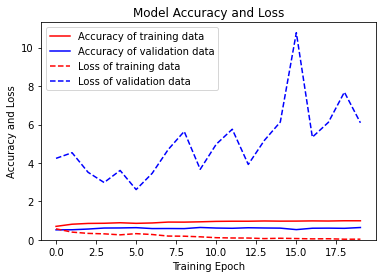

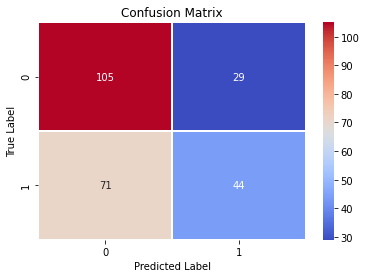

Accuracy: 0.5984
Precision: 0.5994
Recall: 0.5984
F1 Score: 0.5807
Cohen Kappa Score: 0.1706
Matthews Corrcoef: 0.182
ROC AUC: 0.5830953926022064
		Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.78      0.68       134
           1       0.60      0.38      0.47       115

    accuracy                           0.60       249
   macro avg       0.60      0.58      0.57       249
weighted avg       0.60      0.60      0.58       249



In [70]:
y_pred_test = model7.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **Xception Model**

In [28]:
baseModel = Xception(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

83689472/83683744 [==============================] - 3s 0us/step
Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 19s 10ms/step - loss: 0.5464 - accuracy: 0.7341 - val_loss: 14.3541 - val_accuracy: 0.5100
Epoch 2/20
1807/1807 [==============================] - 15s 8ms/step - loss: 0.3833 - accuracy: 0.8417 - val_loss: 28.0843 - val_accuracy: 0.5025
Epoch 3/20
1807/1807 [==============================] - 15s 8ms/step - loss: 0.3046 - accuracy: 0.8791 - val_loss: 44.0473 - val_accuracy: 0.4900
Epoch 4/20
1807/1807 [==============================] - 15s 8ms/step - loss: 0.2875 - accuracy: 0.8907 - val_loss: 66.6242 - val_accuracy: 0.5000
Epoch 5/20
1807/1807 [==============================] - 15s 8ms/step - loss: 0.2479 - accuracy: 0.9073 - val_loss: 47.1427 - val_accuracy: 0.4950
Epoch 6/20
1807/1807 [==============================] - 15s 8ms/step - loss: 0.2054 - accuracy: 0.9303 - val_loss: 36.6815 - val_accuracy: 0.5323
Epoch 7/20


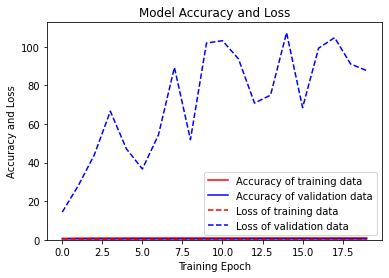

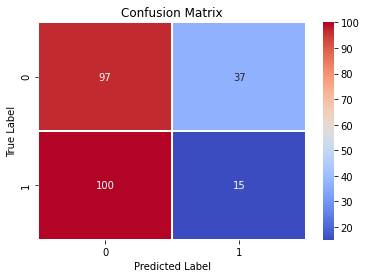

Accuracy: 0.4498
Precision: 0.3982
Recall: 0.4498
F1 Score: 0.3984
Cohen Kappa Score: -0.1516
Matthews Corrcoef: -0.1787
ROC AUC: 0.42715768981181046
		Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.72      0.59       134
           1       0.29      0.13      0.18       115

    accuracy                           0.45       249
   macro avg       0.39      0.43      0.38       249
weighted avg       0.40      0.45      0.40       249



In [29]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **InceptionResNetV2 Model**

In [31]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

219062272/219055592 [==============================] - 7s 0us/step
Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 29s 16ms/step - loss: 0.6062 - accuracy: 0.6638 - val_loss: 80.9146 - val_accuracy: 0.5174
Epoch 2/20
1807/1807 [==============================] - 18s 10ms/step - loss: 0.4747 - accuracy: 0.7784 - val_loss: 33.4718 - val_accuracy: 0.4925
Epoch 3/20
1807/1807 [==============================] - 19s 10ms/step - loss: 0.4274 - accuracy: 0.8135 - val_loss: 178.0467 - val_accuracy: 0.4826
Epoch 4/20
1807/1807 [==============================] - 19s 10ms/step - loss: 0.4119 - accuracy: 0.8116 - val_loss: 91.1988 - val_accuracy: 0.4801
Epoch 5/20
1807/1807 [==============================] - 19s 10ms/step - loss: 0.3677 - accuracy: 0.8423 - val_loss: 280.8860 - val_accuracy: 0.5174
Epoch 6/20
1807/1807 [==============================] - 19s 10ms/step - loss: 0.3457 - accuracy: 0.8556 - val_loss: 144.1609 - val_accuracy: 0.4801
E

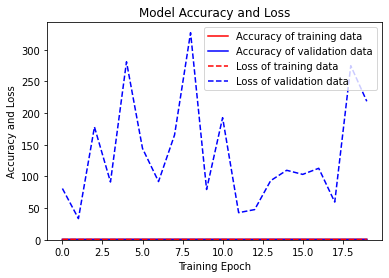

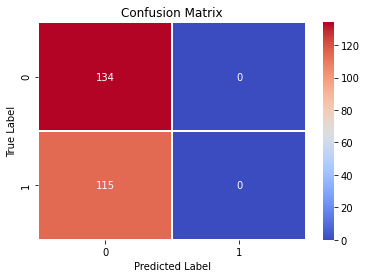

Accuracy: 0.5382
Precision: 0.2896
Recall: 0.5382
F1 Score: 0.3766
Cohen Kappa Score: 0.0
Matthews Corrcoef: 0.0
ROC AUC: 0.5
		Classification Report:
               precision    recall  f1-score   support

           0       0.54      1.00      0.70       134
           1       0.00      0.00      0.00       115

    accuracy                           0.54       249
   macro avg       0.27      0.50      0.35       249
weighted avg       0.29      0.54      0.38       249



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **ResNet Model**

In [49]:
baseModel = ResNet152(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

234700800/234698864 [==============================] - 8s 0us/step
Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 38s 21ms/step - loss: 0.5002 - accuracy: 0.7512 - val_loss: 1.4965 - val_accuracy: 0.5274
Epoch 2/20
1807/1807 [==============================] - 30s 17ms/step - loss: 0.3160 - accuracy: 0.8608 - val_loss: 1.5669 - val_accuracy: 0.5448
Epoch 3/20
1807/1807 [==============================] - 30s 17ms/step - loss: 0.2427 - accuracy: 0.9018 - val_loss: 1.9549 - val_accuracy: 0.5249
Epoch 4/20
1807/1807 [==============================] - 30s 17ms/step - loss: 0.1759 - accuracy: 0.9372 - val_loss: 1.8256 - val_accuracy: 0.5299
Epoch 5/20
1807/1807 [==============================] - 30s 17ms/step - loss: 0.1491 - accuracy: 0.9458 - val_loss: 1.9458 - val_accuracy: 0.5423
Epoch 6/20
1807/1807 [==============================] - 30s 17ms/step - loss: 0.1194 - accuracy: 0.9571 - val_loss: 2.9311 - val_accuracy: 0.5174
Epoch 7/20

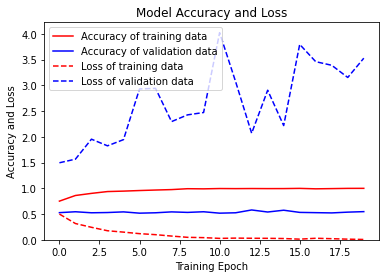

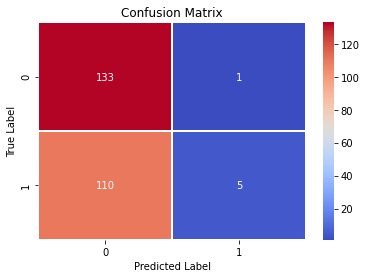

Accuracy: 0.5542
Precision: 0.6794
Recall: 0.5542
F1 Score: 0.4179
Cohen Kappa Score: 0.0386
Matthews Corrcoef: 0.1171
ROC AUC: 0.5180077871512004
		Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.99      0.71       134
           1       0.83      0.04      0.08       115

    accuracy                           0.55       249
   macro avg       0.69      0.52      0.39       249
weighted avg       0.68      0.55      0.42       249



In [50]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()

### **MobileNetV2 Model**

In [51]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_shape=(224, 224, 3))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
predictions = Dense(2, activation='sigmoid')(headModel)

model = Model(inputs=baseModel.input, outputs=predictions)

for layer in baseModel.layers:
	layer.trainable = False
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history= model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.1)
print('CV accuracy:' , np.average(history.history['val_accuracy']))

9412608/9406464 [==============================] - 1s 0us/step
Train on 1807 samples, validate on 201 samples
Epoch 1/20
1807/1807 [==============================] - 10s 5ms/step - loss: 0.5109 - accuracy: 0.7405 - val_loss: 1.0430 - val_accuracy: 0.4801
Epoch 2/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.3396 - accuracy: 0.8489 - val_loss: 0.8130 - val_accuracy: 0.5274
Epoch 3/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.2701 - accuracy: 0.8901 - val_loss: 1.0143 - val_accuracy: 0.4876
Epoch 4/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.2083 - accuracy: 0.9153 - val_loss: 1.1106 - val_accuracy: 0.4801
Epoch 5/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.1641 - accuracy: 0.9380 - val_loss: 0.8815 - val_accuracy: 0.5000
Epoch 6/20
1807/1807 [==============================] - 7s 4ms/step - loss: 0.1409 - accuracy: 0.9510 - val_loss: 0.7538 - val_accuracy: 0.5647
Epoch 7/20
1807/1807 [===

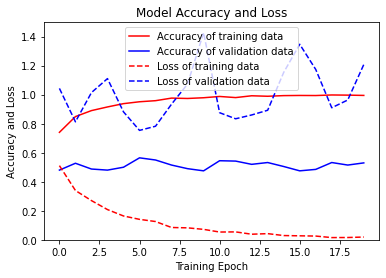

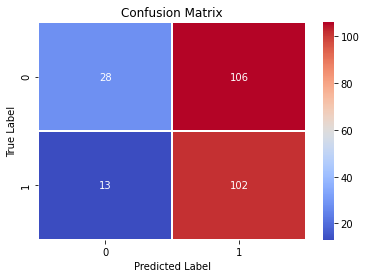

Accuracy: 0.5221
Precision: 0.594
Recall: 0.5221
F1 Score: 0.4639
Cohen Kappa Score: 0.0907
Matthews Corrcoef: 0.1289
ROC AUC: 0.5479558728098637
		Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.21      0.32       134
           1       0.49      0.89      0.63       115

    accuracy                           0.52       249
   macro avg       0.59      0.55      0.48       249
weighted avg       0.59      0.52      0.46       249



In [52]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.round(y_pred_test)
plot_model_accuracy_loss()
print_confusion_matrix()
print_performance_metrics()